In [1]:
# 라이브러리 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import cv2
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow

In [2]:
# train, test, submission 불러오기

train = pd.read_csv('C:/Users/parkk/ais7/petfinder/train.csv',index_col='Id')
test = pd.read_csv('C:/Users/parkk/ais7/petfinder/test.csv',index_col='Id')
submission = pd.read_csv('C:/Users/parkk/ais7/petfinder/sample_submission.csv',index_col='Id')

train.shape, test.shape, submission.shape

((9912, 13), (8, 12), (8, 1))

In [3]:
# path로 저장경로 불러오기

path = Path('C:/Users/parkk/ais7/petfinder')

In [4]:
# 경로에 있는 파일확인해보기

list(path.glob('*'))

[WindowsPath('C:/Users/parkk/ais7/petfinder/sample_submission.csv'),
 WindowsPath('C:/Users/parkk/ais7/petfinder/test'),
 WindowsPath('C:/Users/parkk/ais7/petfinder/test.csv'),
 WindowsPath('C:/Users/parkk/ais7/petfinder/train'),
 WindowsPath('C:/Users/parkk/ais7/petfinder/train.csv')]

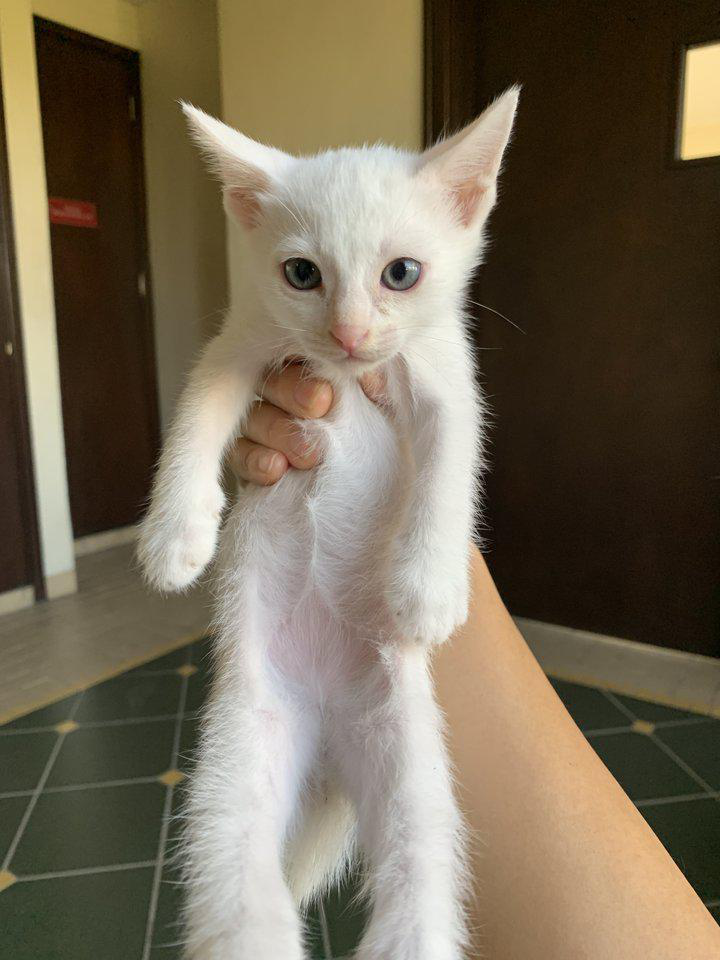

In [5]:
# Image를 이용하여 sample이미지 확인해보기

sampled = train.sample().index[0]
example_path = path / 'train' / (sampled + '.jpg')
im = Image.open(example_path)
im

In [6]:
# img_size 지정해주기

IMG_SIZE = 128

In [7]:
# train_generator와 valid_generator로 할당해주기

train_path = path / 'train'
train.loc[:, 'filename'] = train.index + '.jpg'

datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)

gen_kwargs = dict(
    dataframe=train,
    directory=train_path, 
    x_col='filename',
    y_col='Pawpularity',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE, IMG_SIZE)
)
train_generator = datagen.flow_from_dataframe(**gen_kwargs, subset="training")
valid_generator = datagen.flow_from_dataframe(**gen_kwargs, subset="validation")

Found 7930 validated image filenames.
Found 1982 validated image filenames.


In [8]:
# tensorflow.keras.applications.vgg19에서 16개의 층을 사용하는 VGG16 모델을 불러옵니다.

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1,activation='linear'))

In [9]:
# 모델 요약하기

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 256)      0

In [10]:
# model compile 시켜주기

model.compile(loss = tensorflow.keras.losses.MeanAbsoluteError(), 
              optimizer = 'Adam', 
              metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [11]:
# early_stop callbacks 에 할당해주기

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
# model fit 할당해서 돌려주기

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop],
)
history

Epoch 1/10
248/248 [==============================] - 146s 585ms/step - loss: 15.9454 - rmse: 22.3097 - val_loss: 16.9918 - val_rmse: 24.4731
Epoch 2/10
248/248 [==============================] - 145s 585ms/step - loss: 15.2152 - rmse: 21.4505 - val_loss: 14.8789 - val_rmse: 21.2604
Epoch 3/10
248/248 [==============================] - 144s 579ms/step - loss: 15.0767 - rmse: 21.2953 - val_loss: 14.8788 - val_rmse: 21.3743
Epoch 4/10
248/248 [==============================] - 144s 582ms/step - loss: 15.0560 - rmse: 21.3439 - val_loss: 14.8861 - val_rmse: 21.4247
Epoch 5/10
248/248 [==============================] - 144s 581ms/step - loss: 15.0699 - rmse: 21.3561 - val_loss: 14.8780 - val_rmse: 21.3864
Epoch 6/10
248/248 [==============================] - 145s 583ms/step - loss: 15.0290 - rmse: 21.3597 - val_loss: 15.0456 - val_rmse: 21.9664
Epoch 7/10
248/248 [==============================] - 144s 580ms/step - loss: 15.0737 - rmse: 21.3419 - val_loss: 15.7175 - val_rmse: 20.7231
Epoch 

In [21]:
# fit한 모델을 dataframe으로 만들어주기

df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,rmse,val_loss,val_rmse
5,15.028987,21.359726,15.045550,21.966400
6,15.073709,21.341946,15.717457,20.723059
7,15.034397,21.316059,14.903234,21.032192
8,15.064431,21.304316,15.139731,22.072144
9,14.957542,21.236267,15.035183,20.990370


<AxesSubplot:>

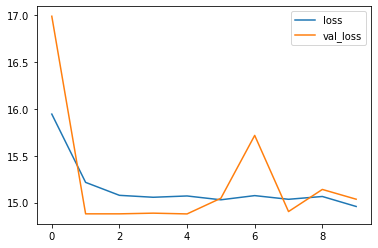

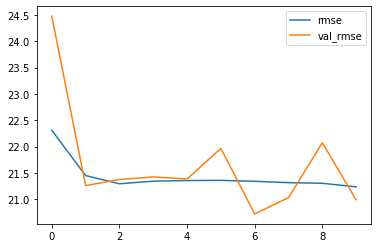

In [22]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
pd.DataFrame(history.history)[['rmse','val_rmse']].plot()

In [23]:
# model evaluate 해주기

model.evaluate(valid_generator)

62/62 [==============================] - 19s 310ms/step - loss: 14.8780 - rmse: 21.3864


[14.877992630004883, 21.386409759521484]

In [24]:
# path 경로로 test_path 지정해주고, test_generator 할당해주기

test_path = path / 'test'

test.loc[:, 'filename'] = test.index + '.jpg'

datagen = ImageDataGenerator(rescale=1/255)

test_generator = datagen.flow_from_dataframe(dataframe=test,
                                             directory=test_path, 
                                             x_col='filename',
                                             y_col=None,
                                             batch_size=32,
                                             seed=42,
                                             shuffle=False,
                                             class_mode=None,
                                             target_size=(IMG_SIZE, IMG_SIZE)
                                            )

Found 8 validated image filenames.


In [25]:
# test_generator를 model.predict로 예측해주기

y_test = model.predict(test_generator, verbose=1)

1/1 [==============================] - 0s 62ms/step


In [26]:
# test와 y_test를 pd.Series로 만들어주고 frames에 할당해주기

frames = [
    pd.Series(test.index.values, name='Id'),
    pd.Series(y_test.ravel(), name='Pawpularity')
]

In [27]:
# submission에 frames를 할당해주기

submission = pd.concat(frames, axis=1)
submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,32.759899
1,43a2262d7738e3d420d453815151079e,32.813488
2,4e429cead1848a298432a0acad014c9d,32.790462
3,80bc3ccafcc51b66303c2c263aa38486,32.849468
4,8f49844c382931444e68dffbe20228f4,32.765240
5,b03f7041962238a7c9d6537e22f9b017,32.795788
6,c978013571258ed6d4637f6e8cc9d6a3,32.844635
7,e0de453c1bffc20c22b072b34b54e50f,32.823696


In [28]:
# submission을 csv파일로 저장해주기

submission.to_csv('submission.csv', index=False)